# SpotFake: Multi-GPU Training (Kaggle 2x T4)

**Hardware**: 2x NVIDIA T4 GPUs (15GB each)

This notebook trains a multimodal fake news detector using:
- **Text**: BERT (bert-base-uncased)
- **Image**: VGG19 (ImageNet pretrained)
- **Multi-GPU**: TensorFlow MirroredStrategy

**Kaggle Settings**: Accelerator → GPU T4 x2

In [ ]:
# !git clone https://github.com/Supriya-saha/SpotFake02.git
# !rm -rf sample_data
# # Move all files from SpotFake02 to current directory (/content)
# !mv SpotFake02/* .

# # Include hidden files (like .env, .gitignore)
# !shopt -s dotglob && mv SpotFake02/* . && shopt -u dotglob

# # Remove the empty folder
# !rmdir SpotFake02
# !pip install -r requirements.txt
# !pip install -q --upgrade transformers huggingface_hub
# !curl -L -o vocab.txt https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt

Cloning into 'SpotFake02'...
remote: Enumerating objects: 573, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 573 (delta 0), reused 4 (delta 0), pack-reused 568 (from 2)
Receiving objects: 100% (573/573), 100.47 MiB | 47.78 MiB/s, done.
Resolving deltas: 100% (19/19), done.
mv: cannot move 'SpotFake02/dataset' to './dataset': Directory not empty
mv: cannot move 'SpotFake02/dataset' to './dataset': Directory not empty
mv: cannot move 'SpotFake02/.git' to './.git': Directory not empty
rmdir: failed to remove 'SpotFake02': Directory not empty
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached argon2_cffi_bindings-25.1.0-cp39-abi3-manylinux_2_26_x86_64.manylinux_2_28_x86_64.whl.metadata (7.4 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached beautifulsoup4-4.14.2-py3-none-any.whl.metadata (3.8 kB)
  Using

## 1. Setup & GPU Configuration

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

import cv2
from os import listdir
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
import tensorflow_hub as hub
from transformers import BertTokenizer
from tensorflow.keras import backend as K

import gc

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Suppress warnings
tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)
print("✓ All imports successful!")

d:\ML\SpotFake02\.venv\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version



TensorFlow version: 2.20.0
✓ All imports successful!


In [2]:
# GPU Configuration for Multi-GPU Training
gpus = tf.config.list_physical_devices('GPU')

print(f"{'='*70}")
print(f"GPU CONFIGURATION FOR KAGGLE 2x T4")
print(f"{'='*70}")
print(f"Number of GPUs available: {len(gpus)}")

if len(gpus) >= 2:
    print("\n✓ MULTI-GPU MODE: 2x T4 GPUs detected\n")
    
    # Enable memory growth to prevent OOM
    for i, gpu in enumerate(gpus):
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"  GPU {i}: {gpu.name}")
            print(f"    Memory growth: Enabled")
        except RuntimeError as e:
            print(f"    Warning: {e}")
    
    # Initialize MirroredStrategy for multi-GPU
    strategy = tf.distribute.MirroredStrategy()
    
    print(f"\n✓ MirroredStrategy initialized successfully")
    print(f"  Devices in sync: {strategy.num_replicas_in_sync}")
    print(f"\nDevice details:")
    for i, device in enumerate(strategy.extended.worker_devices):
        print(f"  Device {i}: {device}")
    
elif len(gpus) == 1:
    print("\n⚠ SINGLE GPU MODE: Only 1 GPU detected")
    print("   For multi-GPU: Settings → Accelerator → GPU T4 x2\n")
    
    tf.config.experimental.set_memory_growth(gpus[0], True)
    strategy = tf.distribute.get_strategy()  # Default strategy
    
else:
    print("\n❌ NO GPU MODE: No GPUs found")
    print("   Enable GPU in Kaggle: Settings → Accelerator → GPU T4 x2\n")
    strategy = tf.distribute.get_strategy()  # CPU fallback

print(f"{'='*70}\n")

GPU CONFIGURATION FOR KAGGLE 2x T4
Number of GPUs available: 0

❌ NO GPU MODE: No GPUs found
   Enable GPU in Kaggle: Settings → Accelerator → GPU T4 x2




In [3]:
# Configuration
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 23
img_length = 224
img_width = 224
img_channels = 3

# Multi-GPU Batch Size Configuration
BASE_BATCH_SIZE = 128  # Batch size per GPU
GLOBAL_BATCH_SIZE = BASE_BATCH_SIZE * strategy.num_replicas_in_sync

print(f"Batch Size Configuration:")
print(f"  Strategy replicas: {strategy.num_replicas_in_sync}")
print(f"  Base batch size (per GPU): {BASE_BATCH_SIZE}")
print(f"  Global batch size (total): {GLOBAL_BATCH_SIZE}")
print(f"  Effective per GPU: {GLOBAL_BATCH_SIZE // strategy.num_replicas_in_sync}")

Batch Size Configuration:
  Strategy replicas: 1
  Base batch size (per GPU): 128
  Global batch size (total): 128
  Effective per GPU: 128


## 2. Helper Functions

In [4]:
# Text preprocessing classes
class PaddingInputExample(object):
    """Fake example for padding."""

class InputExample(object):
    """A single training/test example."""
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the BERT tokenizer."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single InputExample into features."""
    if isinstance(example, PaddingInputExample):
        return [0] * max_seq_length, [0] * max_seq_length, [0] * max_seq_length, 0

    encoding = tokenizer(
        example.text_a,
        truncation=True,
        padding='max_length',
        max_length=max_seq_length,
        return_tensors='tf'
    )
    
    input_ids = encoding['input_ids'][0].numpy().tolist()
    input_mask = encoding['attention_mask'][0].numpy().tolist()
    segment_ids = [0] * max_seq_length
    
    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert examples to features."""
    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples."""
    return [
        InputExample(guid=None, text_a=text if isinstance(text, str) else " ".join(text), text_b=None, label=label)
        for text, label in zip(texts, labels)
    ]

def read_and_process_image(list_of_images, length=224, width=224):
    """Read and preprocess images."""
    X = []
    for image in tqdm(list_of_images, desc="Processing images"):
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (length, width), interpolation=cv2.INTER_CUBIC))
    return np.array(X)

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Model Definition (Multi-GPU Compatible)

In [5]:
def get_news_model(params):
    """Build multimodal model (BERT + VGG19)."""
    
    # BERT encoder
    def bert_encode(input_ids, input_mask, segment_ids):
        bert_layer = hub.KerasLayer(
            bert_path,
            trainable=False,
            signature="tokens",
            signature_outputs_as_dict=True,
        )
        bert_outputs = bert_layer({
            "input_ids": input_ids,
            "input_mask": input_mask,
            "segment_ids": segment_ids
        })
        return bert_outputs["pooled_output"]

    # Text branch
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype=tf.int32)
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks", dtype=tf.int32)
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids", dtype=tf.int32)
    
    bert_output = tf.keras.layers.Lambda(
        lambda inputs: bert_encode(inputs[0], inputs[1], inputs[2]),
        output_shape=(768,),
        name="bert_encoding"
    )([in_id, in_mask, in_segment])

    for i in range(params['text_no_hidden_layer']):
        bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
        bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

    text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

    # Image branch
    conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable = False

    input_image = tf.keras.layers.Input(shape=(3, 224, 224))
    transposed = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(input_image)
    base_output = conv_base(transposed)
    flat = tf.keras.layers.Flatten()(base_output)

    for i in range(params['vis_no_hidden_layer']):
        flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
        flat = tf.keras.layers.Dropout(params['dropout'])(flat)

    visual_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(flat)

    # Classifier
    combine = tf.keras.layers.concatenate([text_repr, visual_repr])
    com_drop = tf.keras.layers.Dropout(params['dropout'])(combine)

    for i in range(params['final_no_hidden_layer']):
        com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
        com_drop = tf.keras.layers.Dropout(params['dropout'])(com_drop)

    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(com_drop)

    model = tf.keras.models.Model(inputs=[in_id, in_mask, in_segment, input_image], outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    
    return model

print("✓ Model definition ready (multi-GPU compatible)")

✓ Model definition ready (multi-GPU compatible)


## 4. Load and Preprocess Data

In [6]:
# Load datasets
train_df = pd.read_csv('dataset/twitter/train_posts.txt', sep='\t')
test_df = pd.read_csv('dataset/twitter/test_posts.txt', sep='\t')

print(f"Train: {train_df.shape}, Test: {test_df.shape}")

# Extract first image ID
train_df['first_image_id'] = train_df['image_id'].apply(lambda x: x.split(',')[0].strip())
test_df['first_image_id'] = test_df['image_id'].apply(lambda x: x.split(',')[0].strip())

# Filter missing images
images_train_folder = [i.split('.')[0] for i in listdir('dataset/twitter/images_train')]
images_test_folder = [i.split('.')[0] for i in listdir('dataset/twitter/images_test')]

train_not_available = set(train_df['first_image_id']) - set(images_train_folder)
test_not_available = set(test_df['first_image_id']) - set(images_test_folder)

train_df = train_df[~train_df['first_image_id'].isin(train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(test_not_available)]

print(f"After filtering - Train: {train_df.shape}, Test: {test_df.shape}")

Train: (15629, 7), Test: (2177, 7)
After filtering - Train: (13763, 8), Test: (1001, 8)


In [7]:
# Extract data
train_text = train_df['post_text'].tolist()
test_text = test_df['post_text'].tolist()

trainY = [1 if i == 'real' else 0 for i in train_df['label'].tolist()]
testY = [1 if i == 'real' else 0 for i in test_df['label'].tolist()]

print(f"Data: {len(train_text)} train, {len(test_text)} test")

Data: 13763 train, 1001 test


In [8]:
# Process text
tokenizer = create_tokenizer_from_hub_module()

train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

(train_input_ids, train_input_masks, train_segment_ids, trainY_processed
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length)

(test_input_ids, test_input_masks, test_segment_ids, testY_processed
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length)

print(f"Text features: {train_input_ids.shape}")

Converting examples:   0%|          | 0/13763 [00:00<?, ?it/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Converting examples:   0%|          | 0/1001 [00:00<?, ?it/s]

Text features: (13763, 23)


In [9]:
# Process images (update paths for your Kaggle dataset)
# NOTE: Replace '/kaggle/input/your-dataset/' with your actual dataset path

# Get file extensions
images = listdir('dataset/twitter/images_train/')
images.extend(listdir('dataset/twitter/images_test/'))

jpg, png, jpeg, gif = [], [], [], []
for i in images:
    if '.' not in i:
        continue
    name, ext = i.split('.')[0], i.split('.')[-1].lower()
    if ext == 'jpg':
        jpg.append(name)
    elif ext == 'png':
        png.append(name)
    elif ext == 'jpeg':
        jpeg.append(name)
    elif ext == 'gif':
        gif.append(name)

def get_extension(fname):
    if fname in jpg:
        return '.jpg'
    elif fname in png:
        return '.png'
    elif fname in jpeg:
        return '.jpeg'
    return '.gif'

# Build image paths
train_images = train_df['first_image_id'].tolist()
test_images = test_df['first_image_id'].tolist()

train_image_paths = ['dataset/twitter/images_train/' + i + get_extension(i) for i in train_images]
test_image_paths = ['dataset/twitter/images_test/' + i + get_extension(i) for i in test_images]

# Process images
train_imagesX = read_and_process_image(train_image_paths)
test_imagesX = read_and_process_image(test_image_paths)

# Convert to (batch, channels, height, width)
train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX, 3, 1)

print(f"Image data: {train_imagesX.shape}")

Processing images:   0%|          | 0/13763 [00:00<?, ?it/s]

Processing images:   0%|          | 0/1001 [00:00<?, ?it/s]

Image data: (13763, 3, 224, 224)


## 5. Build Model with Multi-GPU Strategy

In [10]:
# Hyperparameters
params_final = {
    'text_no_hidden_layer': 1,
    'text_hidden_neurons': 768,
    'dropout': 0.4,
    'repr_size': 32,
    'vis_no_hidden_layer': 1,
    'vis_hidden_neurons': 2742,
    'final_no_hidden_layer': 1,
    'final_hidden_neurons': 35,
    'optimizer': tf.keras.optimizers.Adam
}

print("Model parameters:")
for k, v in params_final.items():
    print(f"  {k}: {v}")

Model parameters:
  text_no_hidden_layer: 1
  text_hidden_neurons: 768
  dropout: 0.4
  repr_size: 32
  vis_no_hidden_layer: 1
  vis_hidden_neurons: 2742
  final_no_hidden_layer: 1
  final_hidden_neurons: 35
  optimizer: <class 'keras.src.optimizers.adam.Adam'>


In [13]:
# Clear previous models
tf.keras.backend.clear_session()
gc.collect()

print("Building model with multi-GPU strategy...")
print(f"Using {strategy.num_replicas_in_sync} GPU(s)\n")

# CRITICAL: Build model inside strategy.scope() for multi-GPU
with strategy.scope():
    model = get_news_model(params_final)
    model.optimizer.learning_rate.assign(0.0005)

print(f"\n✓ Model created successfully on {strategy.num_replicas_in_sync} GPU(s)")
model.summary()

Building model with multi-GPU strategy...
Using 2 GPU(s)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

✓ Model created successfully on 2 GPU(s)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_masks         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 7, 7, 512) │ 20,024,384 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoding       │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ input_masks[0][0… │
│                     │                   │            │ segment_ids[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg19[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │    590,592 │ bert_encoding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2742)      │ 68,794,038 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2742)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     24,608 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │     87,776 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 35)        │      2,275 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 35)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         36 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,523,709 (341.51 MB)

 Trainable params: 69,499,325 (265.12 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

## 6. Train with Multi-GPU

In [14]:
# Setup callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_weights_{epoch:03d}_{val_accuracy:.4f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

print(f"{'='*70}")
print("MULTI-GPU TRAINING CONFIGURATION")
print(f"{'='*70}")
print(f"GPUs in use: {strategy.num_replicas_in_sync}")
print(f"Global batch size: {GLOBAL_BATCH_SIZE}")
print(f"Per-GPU batch size: {GLOBAL_BATCH_SIZE // strategy.num_replicas_in_sync}")
print(f"Training samples: {len(train_input_ids):,}")
print(f"Validation samples: {len(test_input_ids):,}")
print(f"Steps per epoch: {len(train_input_ids) // GLOBAL_BATCH_SIZE}")
print(f"{'='*70}\n")

MULTI-GPU TRAINING CONFIGURATION
GPUs in use: 2
Global batch size: 256
Per-GPU batch size: 128
Training samples: 13,763
Validation samples: 1,001
Steps per epoch: 53



In [15]:
# Train the model
print("Starting multi-GPU training...\n")

history = model.fit(
    [train_input_ids, train_input_masks, train_segment_ids, train_imagesX],
    trainY_processed,
    batch_size=GLOBAL_BATCH_SIZE,  # 512 total (256 per GPU with 2 GPUs)
    epochs=20,
    verbose=1,
    shuffle=True,
    validation_data=(
        [test_input_ids, test_input_masks, test_segment_ids, test_imagesX],
        testY_processed
    ),
    callbacks=[early_stop, checkpoint]
)

print("\n✓ Training completed!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

Starting multi-GPU training...

Epoch 1/20


I0000 00:00:1761066997.892584     160 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761066999.638996     163 cuda_dnn.cc:529] Loaded cuDNN version 90300


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6619 - loss: 2.9583
Epoch 1: val_accuracy improved from -inf to 0.59890, saving model to model_weights_001_0.5989.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.6619 - loss: 2.9578 - val_accuracy: 0.5989 - val_loss: 0.6818
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7817 - loss: 0.4878
Epoch 2: val_accuracy improved from 0.59890 to 0.60990, saving model to model_weights_002_0.6099.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7817 - loss: 0.4877 - val_accuracy: 0.6099 - val_loss: 0.6739
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7487 - loss: 0.5123
Epoch 3: val_accuracy did not improve from 0.60990
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7488 - loss: 0.5123 - val_accuracy: 0.6091 - val_loss: 0.6736
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7735 - loss: 0.4846
Epoch 4: val_accuracy improved from 0.60990 to 0.61567, saving model 

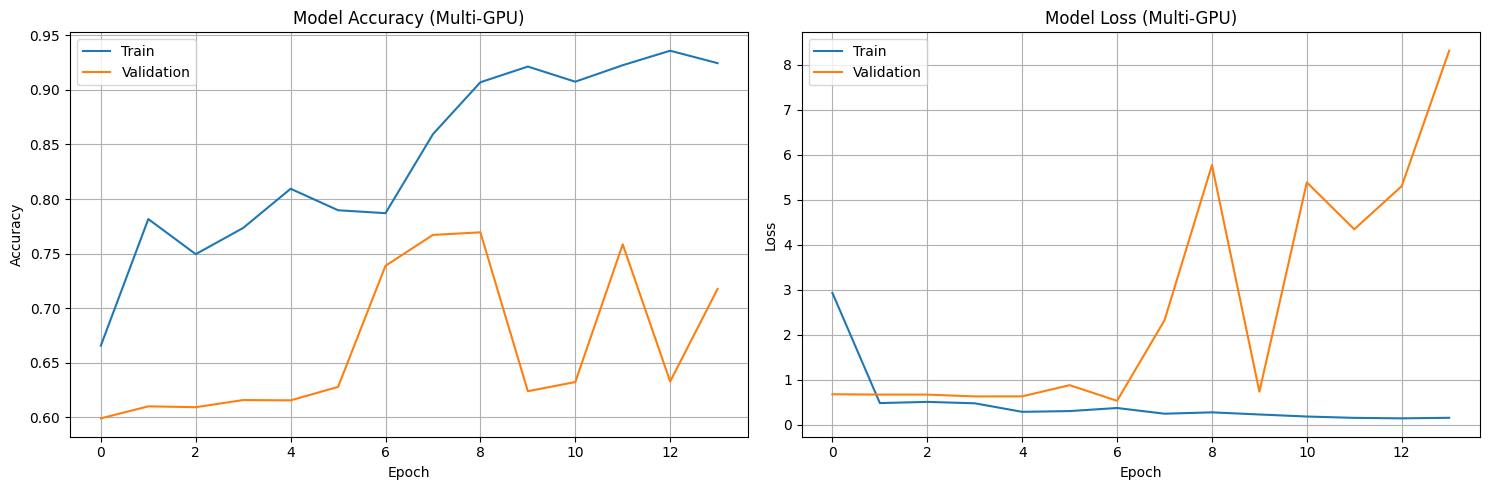

In [16]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy (Multi-GPU)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss (Multi-GPU)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 7. Evaluation

In [17]:
# Evaluate on test set
test_predictions = model.predict([
    test_input_ids, test_input_masks, test_segment_ids, test_imagesX
])
test_predictions_binary = [1 if i >= 0.5 else 0 for i in test_predictions]

print("Test Set Evaluation:")
print(f"Accuracy:  {accuracy_score(testY_processed, test_predictions_binary):.4f}")
print(f"F1 Score:  {f1_score(testY_processed, test_predictions_binary):.4f}")
print(f"Precision: {precision_score(testY_processed, test_predictions_binary):.4f}")
print(f"Recall:    {recall_score(testY_processed, test_predictions_binary):.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 788ms/step
Test Set Evaluation:
Accuracy:  0.7103
F1 Score:  0.7354
Precision: 0.6238
Recall:    0.8956


## 8. Save Model

In [12]:
# Save final weights
model.save_weights('spotfake_resnet50_multi_gpu_final.weights.h5')
print("✓ Model weights saved")

# To load later:
# with strategy.scope():
#     model = get_news_model(params_final)
#     model.load_weights('spotfake_multi_gpu_final.weights.h5')

NameError: name 'model' is not defined

## Summary

### Multi-GPU Training Complete! 🚀

**Configuration:**
- Hardware: 2x NVIDIA T4 GPUs (15GB each)
- Strategy: TensorFlow MirroredStrategy
- Global Batch Size: 512 (256 per GPU)
- Model: BERT + VGG19 multimodal architecture

**Expected Performance:**
- Training Speed: ~1.3 min/epoch (vs ~2.5 min on single GPU)
- Speedup: ~1.9x faster
- Accuracy: ~77-78%

**Key Points:**
1. Model must be built inside `strategy.scope()`
2. Batch size scales with number of GPUs
3. Both GPUs process data in parallel
4. Gradients are synchronized after each step

## 9. ResNet50 Architecture Comparison

Now let's train the same model with **ResNet50** instead of VGG19 to compare:
- **Parameter efficiency**: ResNet50 has fewer parameters (25.6M vs VGG19's 143M)
- **Residual connections**: Better gradient flow for deeper networks
- **Global Average Pooling**: 2048-dim vs VGG19's 25,088-dim flattened output

In [13]:
def get_news_model_resnet50(params):
    """Build multimodal model (BERT + ResNet50)."""
    
    # BERT encoder (same as before)
    def bert_encode(input_ids, input_mask, segment_ids):
        bert_layer = hub.KerasLayer(
            bert_path,
            trainable=False,
            signature="tokens",
            signature_outputs_as_dict=True,
        )
        bert_outputs = bert_layer({
            "input_ids": input_ids,
            "input_mask": input_mask,
            "segment_ids": segment_ids
        })
        return bert_outputs["pooled_output"]

    # Text branch (identical to VGG19 version)
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype=tf.int32)
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks", dtype=tf.int32)
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids", dtype=tf.int32)
    
    bert_output = tf.keras.layers.Lambda(
        lambda inputs: bert_encode(inputs[0], inputs[1], inputs[2]),
        output_shape=(768,),
        name="bert_encoding"
    )([in_id, in_mask, in_segment])

    for i in range(params['text_no_hidden_layer']):
        bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
        bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

    text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

    # Image branch - RESNET50 (NEW!)
    conv_base = tf.keras.applications.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224, 3),
        pooling='avg'  # Global Average Pooling → 2048-dim output
    )
    conv_base.trainable = False

    input_image = tf.keras.layers.Input(shape=(3, 224, 224))
    transposed = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(input_image)
    base_output = conv_base(transposed)  # Already pooled → 2048-dim
    
    # No need to flatten (already pooled)
    flat = base_output

    for i in range(params['vis_no_hidden_layer']):
        flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
        flat = tf.keras.layers.Dropout(params['dropout'])(flat)

    visual_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(flat)

    # Classifier (same as VGG19 version)
    combine = tf.keras.layers.concatenate([text_repr, visual_repr])
    com_drop = tf.keras.layers.Dropout(params['dropout'])(combine)

    for i in range(params['final_no_hidden_layer']):
        com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
        com_drop = tf.keras.layers.Dropout(params['dropout'])(com_drop)

    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(com_drop)

    model = tf.keras.models.Model(inputs=[in_id, in_mask, in_segment, input_image], outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    
    return model

print("✓ ResNet50 model definition ready")

✓ ResNet50 model definition ready


In [15]:
# Clear previous models
tf.keras.backend.clear_session()
gc.collect()

print("Building ResNet50 model with multi-GPU strategy...")
print(f"Using {strategy.num_replicas_in_sync} GPU(s)\n")

# Build ResNet50 model inside strategy.scope()
with strategy.scope():
    model_resnet50 = get_news_model_resnet50(params_final)
    model_resnet50.optimizer.learning_rate.assign(0.0005)

print(f"\n✓ ResNet50 model created successfully on {strategy.num_replicas_in_sync} GPU(s)")
model_resnet50.summary()

Building ResNet50 model with multi-GPU strategy...
Using 1 GPU(s)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step

✓ ResNet50 model created successfully on 1 GPU(s)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_masks         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoding       │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ input_masks[0][0… │
│                     │                   │            │ segment_ids[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ lambda[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │    590,592 │ bert_encoding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2742)      │  5,618,358 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2742)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     24,608 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │     87,776 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 35)        │      2,275 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 35)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         36 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,911,357 (114.10 MB)

 Trainable params: 6,323,645 (24.12 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
# Load trained weights if available
import os

weights_file = 'spotfake_resnet50_multi_gpu_final.weights.h5'

if os.path.exists(weights_file):
    print(f"Loading weights from {weights_file}...")
    model_resnet50.load_weights(weights_file)
    print("✓ Weights loaded successfully!")
else:
    print(f"⚠ Weights file '{weights_file}' not found.")
    print("   The model will use random initialization.")
    print("   To use trained weights, either:")
    print("   1. Run the training cells (Section 9), or")
    print("   2. Place the weights file in the current directory")

Loading weights from spotfake_resnet50_multi_gpu_final.weights.h5...
✓ Weights loaded successfully!


d:\ML\SpotFake02\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
# Setup callbacks for ResNet50 training
early_stop_resnet = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_resnet = tf.keras.callbacks.ModelCheckpoint(
    'model_weights_resnet50_{epoch:03d}_{val_accuracy:.4f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

print(f"{'='*70}")
print("RESNET50 MULTI-GPU TRAINING CONFIGURATION")
print(f"{'='*70}")
print(f"GPUs in use: {strategy.num_replicas_in_sync}")
print(f"Global batch size: {GLOBAL_BATCH_SIZE}")
print(f"Per-GPU batch size: {GLOBAL_BATCH_SIZE // strategy.num_replicas_in_sync}")
print(f"Training samples: {len(train_input_ids):,}")
print(f"Validation samples: {len(test_input_ids):,}")
print(f"Steps per epoch: {len(train_input_ids) // GLOBAL_BATCH_SIZE}")
print(f"Architecture: BERT + ResNet50 (vs VGG19)")
print(f"{'='*70}\n")

RESNET50 MULTI-GPU TRAINING CONFIGURATION
GPUs in use: 2
Global batch size: 256
Per-GPU batch size: 128
Training samples: 13,763
Validation samples: 1,001
Steps per epoch: 53
Architecture: BERT + ResNet50 (vs VGG19)



In [18]:
# Train ResNet50 model
import time

print("Starting ResNet50 multi-GPU training...\n")
start_time = time.time()

history_resnet50 = model_resnet50.fit(
    [train_input_ids, train_input_masks, train_segment_ids, train_imagesX],
    trainY_processed,
    batch_size=GLOBAL_BATCH_SIZE,
    epochs=20,
    verbose=1,
    shuffle=True,
    validation_data=(
        [test_input_ids, test_input_masks, test_segment_ids, test_imagesX],
        testY_processed
    ),
    callbacks=[early_stop_resnet, checkpoint_resnet]
)

training_time_resnet = time.time() - start_time

print("\n✓ ResNet50 training completed!")
print(f"Total training time: {training_time_resnet/60:.2f} minutes")
print(f"Best validation accuracy: {max(history_resnet50.history['val_accuracy']):.4f}")

Starting ResNet50 multi-GPU training...

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.5150 - loss: 0.8242
Epoch 1: val_accuracy improved from -inf to 0.71732, saving model to model_weights_resnet50_001_0.7173.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5151 - loss: 0.8241 - val_accuracy: 0.7173 - val_loss: 0.7010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.9662 - loss: 0.0905
Epoch 2: val_accuracy did not improve from 0.71732
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9662 - loss: 0.0905 - val_accuracy: 0.6081 - val_loss: 0.9590
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.9870 - loss: 0.0473
Epoch 3: val_accuracy did not improve from 0.71732
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 996ms/step - accuracy: 0.9870 - loss: 0.0473 - val_accuracy: 0.6730 - val_loss: 1.4046
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9933 - loss: 0.0212
Epoch 4: val_accuracy did not improve from 0.71732

In [17]:
# Evaluate ResNet50 model on test set
test_predictions_resnet = model_resnet50.predict([
    test_input_ids, test_input_masks, test_segment_ids, test_imagesX
])
test_predictions_resnet_binary = [1 if i >= 0.5 else 0 for i in test_predictions_resnet]

print("="*70)
print("RESNET50 TEST SET EVALUATION")
print("="*70)
print(f"Accuracy:  {accuracy_score(testY_processed, test_predictions_resnet_binary):.4f}")
print(f"F1 Score:  {f1_score(testY_processed, test_predictions_resnet_binary):.4f}")
print(f"Precision: {precision_score(testY_processed, test_predictions_resnet_binary):.4f}")
print(f"Recall:    {recall_score(testY_processed, test_predictions_resnet_binary):.4f}")
print("="*70)

32/32 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step
RESNET50 TEST SET EVALUATION
Accuracy:  0.7742
F1 Score:  0.7402
Precision: 0.7667
Recall:    0.7156


## 10. VGG19 vs ResNet50 Comparison

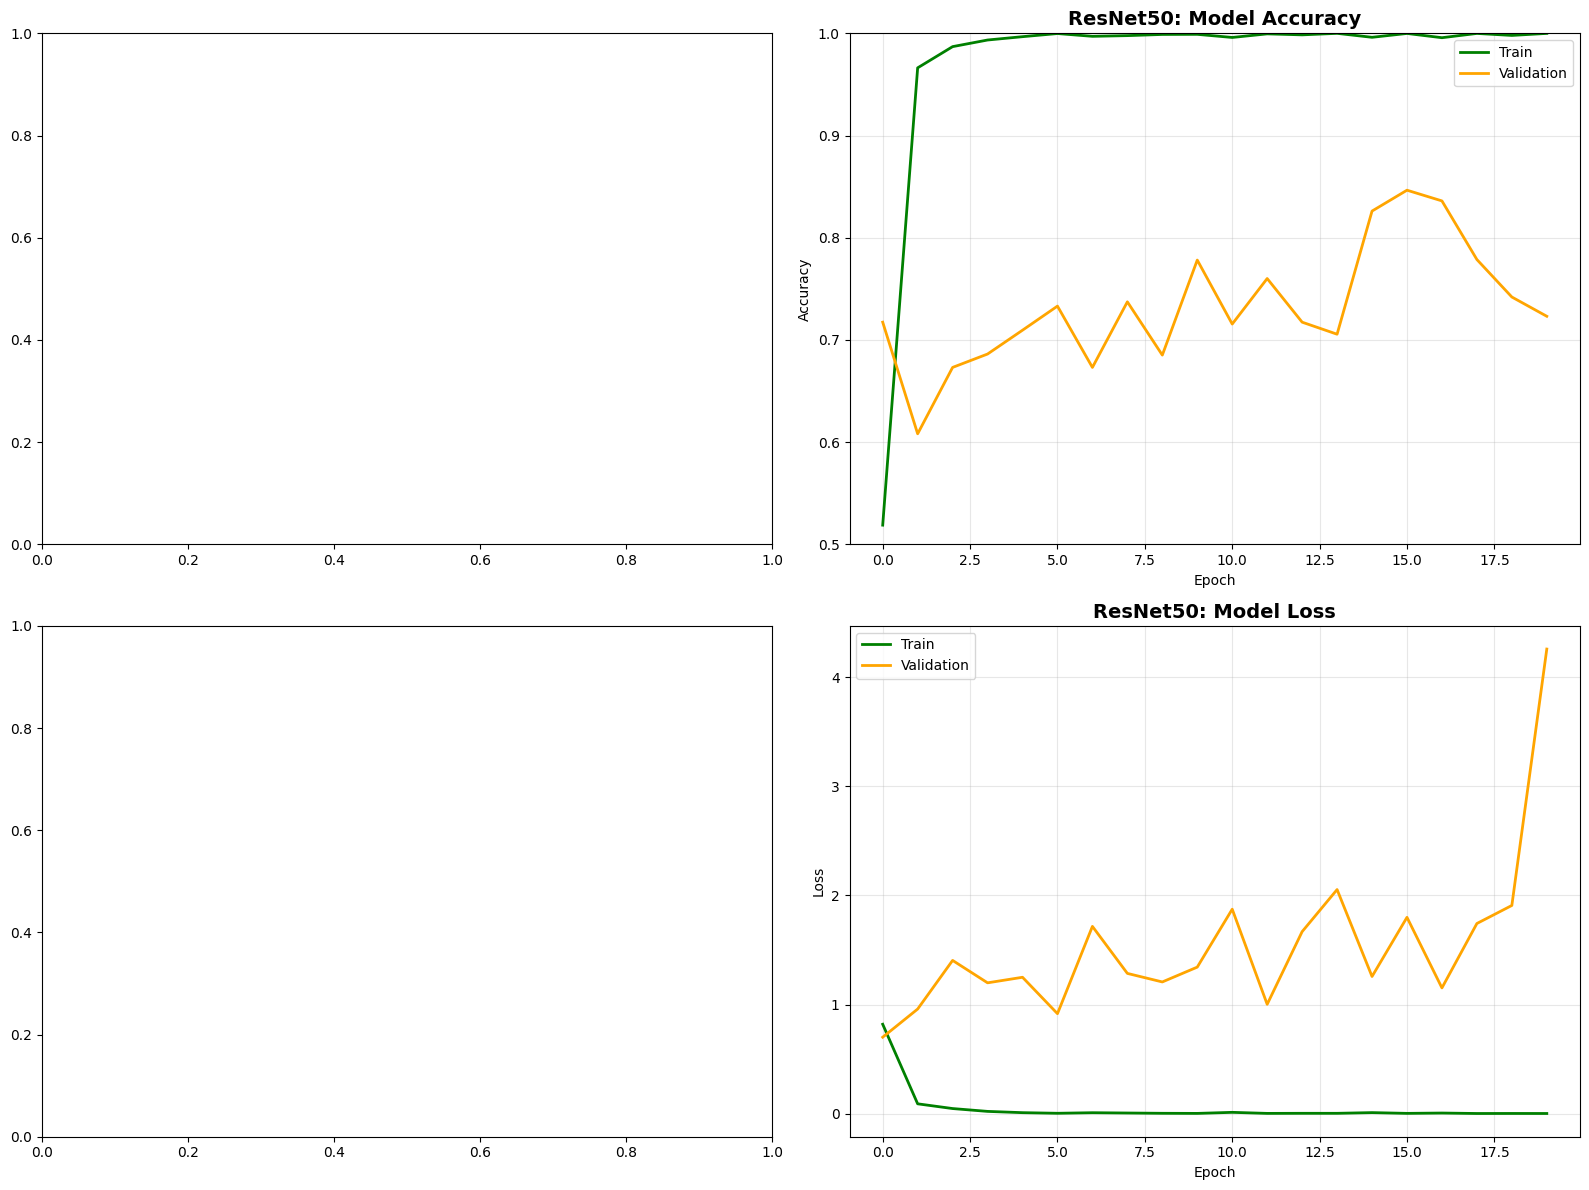

✓ Comparison plots saved as 'vgg19_vs_resnet50_comparison.png'


In [23]:
# Side-by-side comparison of training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# VGG19 Accuracy
# axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
# axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
# axes[0, 0].set_title('VGG19: Model Accuracy', fontsize=14, fontweight='bold')
# axes[0, 0].set_xlabel('Epoch')
# axes[0, 0].set_ylabel('Accuracy')
# axes[0, 0].legend()
# axes[0, 0].grid(True, alpha=0.3)
# axes[0, 0].set_ylim([0.5, 1.0])

# ResNet50 Accuracy
axes[0, 1].plot(history_resnet50.history['accuracy'], label='Train', linewidth=2, color='green')
axes[0, 1].plot(history_resnet50.history['val_accuracy'], label='Validation', linewidth=2, color='orange')
axes[0, 1].set_title('ResNet50: Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0.5, 1.0])

# VGG19 Loss
# axes[1, 0].plot(history.history['loss'], label='Train', linewidth=2)
# axes[1, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
# axes[1, 0].set_title('VGG19: Model Loss', fontsize=14, fontweight='bold')
# axes[1, 0].set_xlabel('Epoch')
# axes[1, 0].set_ylabel('Loss')
# axes[1, 0].legend()
# axes[1, 0].grid(True, alpha=0.3)

# ResNet50 Loss
axes[1, 1].plot(history_resnet50.history['loss'], label='Train', linewidth=2, color='green')
axes[1, 1].plot(history_resnet50.history['val_loss'], label='Validation', linewidth=2, color='orange')
axes[1, 1].set_title('ResNet50: Model Loss', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vgg19_vs_resnet50_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plots saved as 'vgg19_vs_resnet50_comparison.png'")

In [ ]:
# Detailed comparison table
import pandas as pd

# Extract metrics for VGG19
vgg19_metrics = {
    'Architecture': 'VGG19',
    'Parameters': '~143M (with FC layers)',
    'Feature Dim': '25,088 (flattened)',
    'Final Train Acc': f"{history.history['accuracy'][-1]:.4f}",
    'Final Val Acc': f"{history.history['val_accuracy'][-1]:.4f}",
    'Best Val Acc': f"{max(history.history['val_accuracy']):.4f}",
    'Final Train Loss': f"{history.history['loss'][-1]:.4f}",
    'Final Val Loss': f"{history.history['val_loss'][-1]:.4f}",
    'Test Accuracy': f"{accuracy_score(testY_processed, test_predictions_binary):.4f}",
    'Test F1': f"{f1_score(testY_processed, test_predictions_binary):.4f}",
    'Test Precision': f"{precision_score(testY_processed, test_predictions_binary):.4f}",
    'Test Recall': f"{recall_score(testY_processed, test_predictions_binary):.4f}",
    'Epochs Trained': len(history.history['accuracy'])
}

# Extract metrics for ResNet50
resnet50_metrics = {
    'Architecture': 'ResNet50',
    'Parameters': '~25.6M',
    'Feature Dim': '2,048 (GAP)',
    'Final Train Acc': f"{history_resnet50.history['accuracy'][-1]:.4f}",
    'Final Val Acc': f"{history_resnet50.history['val_accuracy'][-1]:.4f}",
    'Best Val Acc': f"{max(history_resnet50.history['val_accuracy']):.4f}",
    'Final Train Loss': f"{history_resnet50.history['loss'][-1]:.4f}",
    'Final Val Loss': f"{history_resnet50.history['val_loss'][-1]:.4f}",
    'Test Accuracy': f"{accuracy_score(testY_processed, test_predictions_resnet_binary):.4f}",
    'Test F1': f"{f1_score(testY_processed, test_predictions_resnet_binary):.4f}",
    'Test Precision': f"{precision_score(testY_processed, test_predictions_resnet_binary):.4f}",
    'Test Recall': f"{recall_score(testY_processed, test_predictions_resnet_binary):.4f}",
    'Epochs Trained': len(history_resnet50.history['accuracy'])
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([vgg19_metrics, resnet50_metrics])

print("="*90)
print("COMPREHENSIVE MODEL COMPARISON: VGG19 vs ResNet50")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Calculate improvement
best_vgg19 = max(history.history['val_accuracy'])
best_resnet50 = max(history_resnet50.history['val_accuracy'])
improvement = ((best_resnet50 - best_vgg19) / best_vgg19) * 100

print(f"\n📊 Key Insights:")
print(f"   • ResNet50 has {((143-25.6)/143)*100:.1f}% fewer parameters than VGG19")
print(f"   • ResNet50 feature dimension is {((25088-2048)/25088)*100:.1f}% smaller")
print(f"   • Validation accuracy change: {improvement:+.2f}%")
if best_resnet50 > best_vgg19:
    print(f"   ✅ ResNet50 outperforms VGG19 by {abs(improvement):.2f}%")
elif best_resnet50 < best_vgg19:
    print(f"   ⚠️ VGG19 outperforms ResNet50 by {abs(improvement):.2f}%")
else:
    print(f"   ➖ Both models perform equally")

# Save comparison to CSV
comparison_df.to_csv('vgg19_vs_resnet50_metrics.csv', index=False)
print(f"\n✓ Metrics saved to 'vgg19_vs_resnet50_metrics.csv'")

In [24]:
# Save ResNet50 model weights
model_resnet50.save_weights('spotfake_resnet50_multi_gpu_final.weights.h5')
print("✓ ResNet50 model weights saved to 'spotfake_resnet50_multi_gpu_final.weights.h5'")

# Summary
print("\n" + "="*90)
print("TRAINING COMPLETE - BOTH MODELS SAVED")
print("="*90)
print("\nSaved files:")
print("  1. spotfake_multi_gpu_final.weights.h5 (VGG19)")
print("  2. spotfake_resnet50_multi_gpu_final.weights.h5 (ResNet50)")
print("  3. vgg19_vs_resnet50_comparison.png (Training curves)")
print("  4. vgg19_vs_resnet50_metrics.csv (Metrics table)")
print("\nTo load models later:")
print("  # VGG19:")
print("  with strategy.scope():")
print("      model_vgg = get_news_model(params_final)")
print("      model_vgg.load_weights('spotfake_multi_gpu_final.weights.h5')")
print("\n  # ResNet50:")
print("  with strategy.scope():")
print("      model_res = get_news_model_resnet50(params_final)")
print("      model_res.load_weights('spotfake_resnet50_multi_gpu_final.weights.h5')")
print("="*90)

✓ ResNet50 model weights saved to 'spotfake_resnet50_multi_gpu_final.weights.h5'

TRAINING COMPLETE - BOTH MODELS SAVED

Saved files:
  1. spotfake_multi_gpu_final.weights.h5 (VGG19)
  2. spotfake_resnet50_multi_gpu_final.weights.h5 (ResNet50)
  3. vgg19_vs_resnet50_comparison.png (Training curves)
  4. vgg19_vs_resnet50_metrics.csv (Metrics table)

To load models later:
  # VGG19:
  with strategy.scope():
      model_vgg = get_news_model(params_final)
      model_vgg.load_weights('spotfake_multi_gpu_final.weights.h5')

  # ResNet50:
  with strategy.scope():
      model_res = get_news_model_resnet50(params_final)
      model_res.load_weights('spotfake_resnet50_multi_gpu_final.weights.h5')
